In [1]:
import pandas as pd
new_file_path = '题目5：fileaccessdata'
new_data = pd.read_csv(new_file_path, delimiter='\t', header=None, names=['Process', 'File'])
 
# 显示新数据的前几行以检查其结构
new_data.head()

,Process,File
0,/usr/bin/whoami,/usr/lib/locale/locale-archive
1,/usr/bin/whoami,/etc/nsswitch.conf
2,/usr/bin/whoami,/etc/ld.so.cache
3,/usr/bin/whoami,/lib64/libnss_files.so.2
4,/usr/bin/whoami,/etc/passwd


In [2]:
import os

# 特征提取：提取路径深度和最后一个目录名/文件名
def extract_features(data):
    data['Process_Depth'] = data['Process'].apply(lambda x: len(x.split('/')) - 1)
    data['File_Depth'] = data['File'].apply(lambda x: len(x.split('/')) - 1)
    data['Process_Last_Dir'] = data['Process'].apply(lambda x: os.path.basename(os.path.dirname(x)))
    data['File_Last_Dir'] = data['File'].apply(lambda x: os.path.basename(os.path.dirname(x)))
    data['Process_Base'] = data['Process'].apply(lambda x: os.path.basename(x))
    data['File_Base'] = data['File'].apply(lambda x: os.path.basename(x))
    return data

# 应用特征提取
featured_data = extract_features(new_data.copy())

# 显示添加了特征的数据
featured_data.head()


,Process,File,Process_Depth,File_Depth,Process_Last_Dir,File_Last_Dir,Process_Base,File_Base
0,/usr/bin/whoami,/usr/lib/locale/locale-archive,3,4,bin,locale,whoami,locale-archive
1,/usr/bin/whoami,/etc/nsswitch.conf,3,2,bin,etc,whoami,nsswitch.conf
2,/usr/bin/whoami,/etc/ld.so.cache,3,2,bin,etc,whoami,ld.so.cache
3,/usr/bin/whoami,/lib64/libnss_files.so.2,3,2,bin,lib64,whoami,libnss_files.so.2
4,/usr/bin/whoami,/etc/passwd,3,2,bin,etc,whoami,passwd


In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

# 准备数据用于聚类
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(featured_data[['Process_Last_Dir', 'File_Last_Dir', 'Process_Base', 'File_Base']]).toarray()

# 应用 K-means 聚类
kmeans = KMeans(n_clusters=5, random_state=42)  # 可以调整簇的数量来看不同的聚类效果
clusters = kmeans.fit_predict(encoded_features)

# 将聚类结果添加到数据框中
featured_data['Cluster'] = clusters

# 显示聚类后的数据
print(featured_data.head())


           Process                            File  Process_Depth  File_Depth  \
0  /usr/bin/whoami  /usr/lib/locale/locale-archive              3           4   
1  /usr/bin/whoami              /etc/nsswitch.conf              3           2   
2  /usr/bin/whoami                /etc/ld.so.cache              3           2   
3  /usr/bin/whoami        /lib64/libnss_files.so.2              3           2   
4  /usr/bin/whoami                     /etc/passwd              3           2   

  Process_Last_Dir File_Last_Dir Process_Base          File_Base  Cluster  
0              bin        locale       whoami     locale-archive        2  
1              bin           etc       whoami      nsswitch.conf        3  
2              bin           etc       whoami        ld.so.cache        3  
3              bin         lib64       whoami  libnss_files.so.2        1  
4              bin           etc       whoami             passwd        3  


In [4]:
import os

# 生成每个聚类的白名单规则
rules = []
for cluster in featured_data['Cluster'].unique():
    cluster_data = featured_data[featured_data['Cluster'] == cluster]
    most_common_process = cluster_data['Process'].mode()[0]
    most_common_file = cluster_data['File'].mode()[0]
    
    # 简化规则：使用通配符替换最后的文件名和进程名
    process_rule = os.path.dirname(most_common_process) + '/*'
    file_rule = os.path.dirname(most_common_file) + '/*'
    
    rules.append((process_rule, file_rule))

# 显示生成的规则
for rule in rules:
    print("Process rule:", rule[0], "File rule:", rule[1])


Process rule: /usr/bin/* File rule: /usr/lib/locale/*
Process rule: /usr/bin/* File rule: /etc/*
Process rule: /usr/bin/* File rule: /lib64/*
Process rule: /usr/sbin/* File rule: /etc/*
Process rule: /usr/bin/* File rule: /dev/*


性能测试

In [6]:
import fnmatch

def verify_rules(data, rules):
    # 验证规则的覆盖率和错误率
    covered = 0
    missed = 0
    for index, row in data.iterrows():
        match = False
        for process_rule, file_rule in rules:
            if fnmatch.fnmatch(row['Process'], process_rule) and fnmatch.fnmatch(row['File'], file_rule):
                match = True
                break
        if match:
            covered += 1
        else:
            missed += 1
    
    coverage = covered / len(data) * 100
    error_rate = missed / len(data) * 100
    return coverage, error_rate


# 执行规则验证
coverage, error_rate = verify_rules(featured_data, rules)
print(f"Coverage: {coverage:.2f}%")
print(f"Error Rate: {error_rate:.2f}%")


Coverage: 71.95%
Error Rate: 28.05%


In [1]:
import pandas as pd
import os
import fnmatch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

# 提取路径特征
def path_to_features(paths, max_features=100):
    vectorizer = CountVectorizer(ngram_range=(1, 3), analyzer='char_wb', max_features=max_features)
    features = vectorizer.fit_transform(paths).toarray()
    return features

def load_and_extract_features(file_path):
    data = pd.read_csv(file_path, delimiter='\t', header=None, names=['Process', 'File'])
    
    # 提取路径特征
    process_features = path_to_features(data['Process'])
    file_features = path_to_features(data['File'])
    
    # 添加基础特征
    data['Process_Base'] = data['Process'].apply(lambda x: os.path.basename(x))
    data['File_Base'] = data['File'].apply(lambda x: os.path.basename(x))
    
    return data, process_features, file_features

def is_rule_subset(general_rule, specific_rule):
    process_general, file_general = general_rule
    process_specific, file_specific = specific_rule
    process_match = fnmatch.fnmatch(process_specific, process_general)
    file_match = fnmatch.fnmatch(file_specific, file_general)
    return process_match and file_match

def filter_redundant_rules(rules):
    filtered_rules = []
    for rule in rules:
        if not any(is_rule_subset(other_rule, rule) for other_rule in rules if other_rule != rule):
            filtered_rules.append(rule)
    return filtered_rules

def generate_specific_rules(cluster_data):
    """生成更具体的规则，而不是使用 commonpath 或 commonprefix"""
    process_paths = cluster_data['Process'].tolist()
    file_paths = cluster_data['File'].tolist()
    
    # 分别对每个路径生成规则，结合所有路径找到通用模式
    process_rule = os.path.commonprefix(process_paths).rstrip('/')
    file_rule = os.path.commonprefix(file_paths).rstrip('/')
    
    if not process_rule.endswith('*'):
        process_rule += '*'
    if not file_rule.endswith('*'):
        file_rule += '*'
    
    return process_rule, file_rule

def apply_clustering_and_generate_rules(data, process_features, file_features):
    encoder = OneHotEncoder()
    basic_features = encoder.fit_transform(data[['Process_Base', 'File_Base']]).toarray()
    features = np.concatenate((basic_features, process_features, file_features), axis=1)
    
    # 使用KMeans聚类
    kmeans = KMeans(n_clusters=20, random_state=42)
    clusters = kmeans.fit_predict(features)
    
    data['Cluster'] = clusters
    rules = set()
    
    for cluster in set(clusters):
        if cluster != -1:
            cluster_data = data[data['Cluster'] == cluster]
            process_rule, file_rule = generate_specific_rules(cluster_data)
            rules.add((process_rule, file_rule))
    
    rules = filter_redundant_rules(list(rules))
    
    return rules

def verify_rules(data, rules):
    covered = 0
    missed = 0
    for index, row in data.iterrows():
        match = False
        for process_rule, file_rule in rules:
            if fnmatch.fnmatch(row['Process'], process_rule) and fnmatch.fnmatch(row['File'], file_rule):
                match = True
                break
        if match:
            covered += 1
        else:
            missed += 1
    coverage = covered / len(data) * 100
    error_rate = missed / len(data) * 100
    return coverage, error_rate

def main():
    file_path = '题目5：fileaccessdata'  
    data, process_features, file_features = load_and_extract_features(file_path)
    rules = apply_clustering_and_generate_rules(data, process_features, file_features)
    coverage, error_rate = verify_rules(data, rules)
    print("Generated Rules:")
    for rule in rules:
        print("Process rule:", rule[0], "File rule:", rule[1])
    print(f"Coverage: {coverage:.2f}%")
    print(f"Error Rate: {error_rate:.2f}%")

if __name__ == "__main__":
    main()


Generated Rules:
Process rule: * File rule: *
Coverage: 100.00%
Error Rate: 0.00%


In [3]:
import os
import pandas as pd
import fnmatch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

def path_to_features(paths, max_features=100):
    vectorizer = CountVectorizer(ngram_range=(1, 3), analyzer='char_wb', max_features=max_features)
    features = vectorizer.fit_transform(paths).toarray()
    return features

def load_and_extract_features(file_path):
    data = pd.read_csv(file_path, delimiter='\t', header=None, names=['Process', 'File'])
    
    process_features = path_to_features(data['Process'])
    file_features = path_to_features(data['File'])
    
    data['Process_Base'] = data['Process'].apply(lambda x: os.path.basename(x))
    data['File_Base'] = data['File'].apply(lambda x: os.path.basename(x))
    
    return data, process_features, file_features

def is_rule_subset(general_rule, specific_rule):
    process_general, file_general = general_rule
    process_specific, file_specific = specific_rule
    process_match = fnmatch.fnmatch(process_specific, process_general)
    file_match = fnmatch.fnmatch(file_specific, file_general)
    return process_match and file_match

def filter_redundant_rules(rules):
    filtered_rules = []
    for rule in rules:
        if not any(is_rule_subset(other_rule, rule) for other_rule in rules if other_rule != rule):
            filtered_rules.append(rule)
    return filtered_rules

def generate_specific_rules(cluster_data):
    process_paths = cluster_data['Process'].tolist()
    file_paths = cluster_data['File'].tolist()
    
    process_rule = os.path.commonprefix(process_paths).rstrip('/')
    file_rule = os.path.commonprefix(file_paths).rstrip('/')
    
    if len(process_rule.split('/')) <= 2:
        process_rule = os.path.dirname(process_rule) + '/*'
    else:
        process_rule += '/*'
    
    if len(file_rule.split('/')) <= 2:
        file_rule = os.path.dirname(file_rule) + '/*'
    else:
        file_rule += '/*'
    
    return process_rule, file_rule

def apply_clustering_and_generate_rules(data, process_features, file_features):
    encoder = OneHotEncoder()
    basic_features = encoder.fit_transform(data[['Process_Base', 'File_Base']]).toarray()
    features = np.concatenate((basic_features, process_features, file_features), axis=1)
    
    kmeans = KMeans(n_clusters=20, random_state=42)
    clusters = kmeans.fit_predict(features)
    
    data['Cluster'] = clusters
    rules = set()
    
    for cluster in set(clusters):
        if cluster != -1:
            cluster_data = data[data['Cluster'] == cluster]
            process_rule, file_rule = generate_specific_rules(cluster_data)
            rules.add((process_rule, file_rule))
    
    rules = filter_redundant_rules(list(rules))
    
    return rules

def verify_rules(data, rules):
    covered = 0
    missed = 0
    for index, row in data.iterrows():
        match = False
        for process_rule, file_rule in rules:
            if fnmatch.fnmatch(row['Process'], process_rule) and fnmatch.fnmatch(row['File'], file_rule):
                match = True
                break
        if match:
            covered += 1
        else:
            missed += 1
    coverage = covered / len(data) * 100
    error_rate = missed / len(data) * 100
    return coverage, error_rate

def main():
    file_path = '题目5：fileaccessdata'  
    data, process_features, file_features = load_and_extract_features(file_path)
    rules = apply_clustering_and_generate_rules(data, process_features, file_features)
    
    print("Generated Rules:")
    for rule in rules:
        print("Process rule:", rule[0], "File rule:", rule[1])

    coverage, error_rate = verify_rules(data, rules)
    print(f"Coverage: {coverage:.2f}%")
    print(f"Error Rate: {error_rate:.2f}%")

if __name__ == "__main__":
    main()


Generated Rules:
Process rule: /* File rule: /*
Coverage: 99.45%
Error Rate: 0.55%


In [10]:
import pandas as pd
import os
import fnmatch
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix

def load_and_extract_features(file_path):
    """加载数据并提取特征"""
    data = pd.read_csv(file_path, delimiter='\t', header=None, names=['Process', 'File'])
    data['Process_Depth'] = data['Process'].apply(lambda x: len(x.split('/')) - 1)
    data['File_Depth'] = data['File'].apply(lambda x: len(x.split('/')) - 1)
    data['Process_Last_Dir'] = data['Process'].apply(lambda x: os.path.dirname(x).split('/')[-1] if '/' in x else '')
    data['File_Last_Dir'] = data['File'].apply(lambda x: os.path.dirname(x).split('/')[-1] if '/' in x else '')
    data['Process_Base'] = data['Process'].apply(lambda x: os.path.basename(x))
    data['File_Base'] = data['File'].apply(lambda x: os.path.basename(x))

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100)
    process_tfidf = tfidf_vectorizer.fit_transform(data['Process']).toarray()
    file_tfidf = tfidf_vectorizer.fit_transform(data['File']).toarray()
    return data, process_tfidf, file_tfidf

def apply_clustering_and_generate_rules(data, process_tfidf, file_tfidf):
    """应用聚类算法并生成规则，同时去重，使用KMeans聚类"""
    encoder = OneHotEncoder()
    basic_features = encoder.fit_transform(data[['Process_Last_Dir', 'File_Last_Dir', 'Process_Base', 'File_Base']]).toarray()
    features = np.concatenate((basic_features, process_tfidf, file_tfidf), axis=1)
    
    kmeans = KMeans(n_clusters=10, random_state=0)
    clusters = kmeans.fit_predict(features)
    data['Cluster'] = clusters
    
    rules_set = set()
    for cluster in set(clusters):
        cluster_data = data[data['Cluster'] == cluster]
        most_common_process = cluster_data['Process'].mode()[0]
        most_common_file = cluster_data['File'].mode()[0]
        rule = (os.path.dirname(most_common_process) + '/*', os.path.dirname(most_common_file) + '/*')
        rules_set.add(rule)
    return list(rules_set)

def verify_rules(data, rules):
    """验证生成的规则，并计算覆盖率和错误率"""
    matches = 0
    total = len(data)
    for index, row in data.iterrows():
        matched = any(fnmatch.fnmatch(row['Process'], rule[0]) and fnmatch.fnmatch(row['File'], rule[1]) for rule in rules)
        if matched:
            matches += 1

    coverage = matches / total * 100
    print(f"Coverage: {coverage:.2f}%")
    print(f"Matches: {matches} of {total}")

def main():
    """主执行函数"""
    file_path = '题目5：fileaccessdata'  # 确保文件路径正确
    data, process_tfidf, file_tfidf = load_and_extract_features(file_path)
    rules = apply_clustering_and_generate_rules(data, process_tfidf, file_tfidf)
    print("Generated Rules:")
    for rule in rules:
        print(f"Process rule: {rule[0]}, File rule: {rule[1]}")
    verify_rules(data, rules)

if __name__ == "__main__":
    main()


Generated Rules:
Process rule: /usr/bin/*, File rule: /etc/*
Process rule: /usr/bin/*, File rule: /dev/*
Process rule: /usr/sbin/*, File rule: /etc/*
Process rule: /usr/bin/*, File rule: /lib64/*
Process rule: /usr/local/hostguard/bin/*, File rule: /sys/fs/cgroup/memory/*
Process rule: /usr/bin/*, File rule: /usr/share/locale/en_US.UTF-8/LC_MESSAGES/*
Process rule: /usr/bin/*, File rule: /usr/lib/locale/*
Coverage: 75.43%
Matches: 37976 of 50347


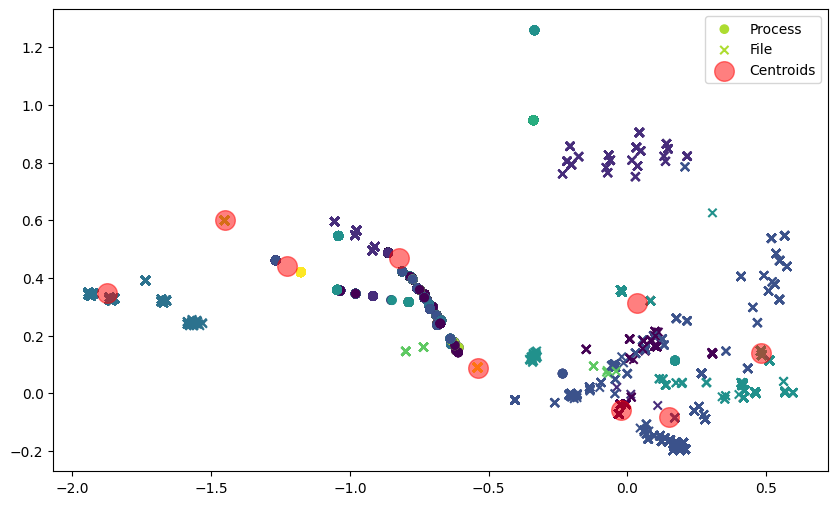

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec

def tokenize_and_embed_paths(data):
    """使用NLP技术分词和嵌入路径"""
    tokenizer = RegexpTokenizer(r'[\\\/]+', gaps=True)
    data['Process_tokens'] = data['Process'].apply(lambda x: tokenizer.tokenize(x))
    data['File_tokens'] = data['File'].apply(lambda x: tokenizer.tokenize(x))
    
    # 训练词嵌入模型
    all_tokens = data['Process_tokens'].tolist() + data['File_tokens'].tolist()
    model = Word2Vec(sentences=all_tokens, vector_size=50, window=5, min_count=1, workers=4)
    
    # 生成向量表示
    data['Process_vec'] = data['Process_tokens'].apply(lambda tokens: np.mean([model.wv[token] for token in tokens if token in model.wv], axis=0))
    data['File_vec'] = data['File_tokens'].apply(lambda tokens: np.mean([model.wv[token] for token in tokens if token in model.wv], axis=0))
    return data

def apply_clustering(data):
    """应用聚类并动态选择最佳簇数"""
    process_vectors = np.vstack(data['Process_vec'].dropna())  # 处理可能的NaN值
    file_vectors = np.vstack(data['File_vec'].dropna())
    
    # 结合向量进行聚类
    X = np.vstack((process_vectors, file_vectors))
    best_score = -1
    best_k = 2
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_k = k
    
    # 重新聚类以确定最佳簇数
    final_kmeans = KMeans(n_clusters=best_k, random_state=0)
    final_kmeans.fit(X)
    labels = final_kmeans.labels_
    
    # 将标签分配回对应的行
    data['Cluster'] = None  # 初始化列
    data.loc[data['Process_vec'].dropna().index, 'Cluster'] = labels[:len(process_vectors)]
    data.loc[data['File_vec'].dropna().index, 'Cluster'] = labels[len(process_vectors):]
    
    return data, final_kmeans.cluster_centers_

def visualize_clusters(data, centers):
    """可视化聚类结果"""
    plt.figure(figsize=(10, 6))
    plt.scatter(data['Process_vec'].dropna().apply(lambda x: x[0]), data['Process_vec'].dropna().apply(lambda x: x[1]), c=data['Cluster'].dropna(), cmap='viridis', marker='o', label='Process')
    plt.scatter(data['File_vec'].dropna().apply(lambda x: x[0]), data['File_vec'].dropna().apply(lambda x: x[1]), c=data['Cluster'].dropna(), cmap='viridis', marker='x', label='File')
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, label='Centroids')
    plt.legend()
    plt.show()

def main():
    file_path = '题目5：fileaccessdata'
    data = pd.read_csv(file_path, delimiter='\t', header=None, names=['Process', 'File'])
    data = tokenize_and_embed_paths(data)
    data, centers = apply_clustering(data)
    visualize_clusters(data, centers)

if __name__ == "__main__":
    main()


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import os

def load_data(file_path):
    data = pd.read_csv(file_path, delimiter='\t', header=None, names=['Process', 'File'])
    return data

def vectorize_data(data):
    vectorizer = TfidfVectorizer(max_features=100)  # 使用TF-IDF向量化，限制最大特征数以提高速度
    process_vec = vectorizer.fit_transform(data['Process']).toarray()
    file_vec = vectorizer.fit_transform(data['File']).toarray()
    return process_vec, file_vec

def cluster_data(process_vec, file_vec):
    combined_vec = np.hstack((process_vec, file_vec))
    kmeans = KMeans(n_clusters=10, random_state=42)
    labels = kmeans.fit_predict(combined_vec)
    return labels

def generate_rules(data, labels):
    rules = {}
    for cluster_id in set(labels):
        cluster_data = data[labels == cluster_id]
        process_rule = os.path.dirname(cluster_data['Process'].mode()[0]) + '/*'
        file_rule = os.path.dirname(cluster_data['File'].mode()[0]) + '/*'
        rules[cluster_id] = (process_rule, file_rule)
    return rules

def calculate_coverage(data, rules):
    matches = 0
    for _, row in data.iterrows():
        for rule in rules.values():
            if fnmatch.fnmatch(row['Process'], rule[0]) and fnmatch.fnmatch(row['File'], rule[1]):
                matches += 1
                break
    coverage = matches / len(data) * 100
    return coverage, matches

def main():
    file_path = '题目5：fileaccessdata'
    data = load_data(file_path)
    process_vec, file_vec = vectorize_data(data)
    labels = cluster_data(process_vec, file_vec)
    rules = generate_rules(data, labels)
    coverage, matches = calculate_coverage(data, rules)

    print("Generated Rules:")
    for rule in rules.values():
        print(f"Process rule: {rule[0]}, File rule: {rule[1]}")
    print(f"Coverage: {coverage:.2f}%")
    print(f"Matches: {matches} of {len(data)}")

if __name__ == "__main__":
    main()


NameError: name 'fnmatch' is not defined

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
import os
import fnmatch

def load_data(file_path):
    return pd.read_csv(file_path, delimiter='\t', header=None, names=['Process', 'File'])

def vectorize_data(data):
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split('/'), max_features=50)
    process_vec = vectorizer.fit_transform(data['Process']).toarray()
    file_vec = vectorizer.fit_transform(data['File']).toarray()
    return process_vec, file_vec

def cluster_data(process_vec, file_vec):
    combined_vec = np.hstack((process_vec, file_vec))
    mini_kmeans = MiniBatchKMeans(n_clusters=10, random_state=42)
    labels = mini_kmeans.fit_predict(combined_vec)
    return labels

def generate_detailed_rules(data, labels):
    rules = {}
    for cluster_id in set(labels):
        cluster_data = data.iloc[labels == cluster_id]
        if not cluster_data.empty:
            process_rules = set(cluster_data['Process'].apply(lambda x: os.path.dirname(x) + '/*'))
            file_rules = set(cluster_data['File'].apply(lambda x: os.path.dirname(x) + '/*'))
            rules[cluster_id] = (process_rules, file_rules)
    return rules

def remove_redundant_rules(rules):
    # Simplify rules by removing redundancies
    final_rules = []
    for process_rules, file_rules in rules.values():
        processed_file_rules = set()
        for file_rule in sorted(file_rules, key=lambda x: x.count('/'), reverse=True):
            if not any(fnmatch.fnmatch(file_rule, f_rule) for f_rule in processed_file_rules if f_rule != file_rule):
                processed_file_rules.add(file_rule)
        for process_rule in process_rules:
            final_rules.append((process_rule, processed_file_rules))
    return final_rules

def calculate_coverage(data, rules):
    matches = 0
    for _, row in data.iterrows():
        for process_rule, file_rules in rules:
            if fnmatch.fnmatch(row['Process'], process_rule) and any(fnmatch.fnmatch(row['File'], file_rule) for file_rule in file_rules):
                matches += 1
                break
    coverage = matches / len(data) * 100
    return coverage, matches

def main():
    file_path = '题目5：fileaccessdata'  # Adjust the path as needed
    data = load_data(file_path)
    process_vec, file_vec = vectorize_data(data)
    labels = cluster_data(process_vec, file_vec)
    rules = generate_detailed_rules(data, labels)
    refined_rules = remove_redundant_rules(rules)
    coverage, matches = calculate_coverage(data, refined_rules)

    print("Generated Rules:")
    for process_rule, file_rules in refined_rules:
        for file_rule in file_rules:
            print(f"Process rule: {process_rule}, File rule: {file_rule}")
    print(f"Coverage: {coverage:.2f}%")
    print(f"Matches: {matches} of {len(data)}")

if __name__ == "__main__":
    main()


c:\Program Files\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Generated Rules:
Process rule: /usr/bin/*, File rule: /usr/lib64/gconv/*
Process rule: /usr/bin/*, File rule: /run/systemd/*
Process rule: /usr/bin/*, File rule: /usr/lib64/elfutils/tls/*
Process rule: /usr/bin/*, File rule: /usr/lib64/tls/*
Process rule: /usr/bin/*, File rule: /sys/fs/cgroup/systemd/system.slice/system-hostos.slice/irqbalance.service/*
Process rule: /usr/bin/*, File rule: /root/*
Process rule: /usr/bin/*, File rule: /var/run/*
Process rule: /usr/bin/*, File rule: /run/log/journal/d0e9f228fd304dfcb232a1381fa6432b/*
Process rule: /usr/bin/*, File rule: /usr/lib64/man-db/x86_64/*
Process rule: /usr/bin/*, File rule: x86_64/*
Process rule: /usr/bin/*, File rule: /usr/lib64/x86_64/*
Process rule: /usr/bin/*, File rule: /usr/lib64/elfutils/tls/x86_64/*
Process rule: /usr/bin/*, File rule: /usr/lib64/man-db/*
Process rule: /usr/bin/*, File rule: /usr/lib64/man-db/tls/*
Process rule: /usr/bin/*, File rule: tls/x86_64/*
Process rule: /usr/bin/*, File rule: /usr/lib64/man-db/tl

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
import os
import fnmatch

# 载入数据
def load_data(file_path):
    return pd.read_csv(file_path, delimiter='\t', header=None, names=['Process', 'File'])

# 数据向量化
def vectorize_data(data):
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split('/'), max_features=50)
    process_vec = vectorizer.fit_transform(data['Process']).toarray()
    file_vec = vectorizer.fit_transform(data['File']).toarray()
    return process_vec, file_vec

# 数据聚类
def cluster_data(process_vec, file_vec):
    combined_vec = np.hstack((process_vec, file_vec))
    mini_kmeans = MiniBatchKMeans(n_clusters=10, random_state=42)
    labels = mini_kmeans.fit_predict(combined_vec)
    return labels

# 生成详细的规则
def generate_detailed_rules(data, labels):
    rules = {}
    for cluster_id in set(labels):
        cluster_data = data.iloc[labels == cluster_id]
        if not cluster_data.empty:
            process_rules = set(cluster_data['Process'].apply(lambda x: os.path.dirname(x) + '/*').unique())
            file_rules = set(cluster_data['File'].apply(lambda x: os.path.dirname(x) + '/*').unique())
            rules[cluster_id] = (process_rules, file_rules)
    return rules

# 删除冗余规则
def remove_redundant_rules(rules):
    final_rules = []
    for process_rules, file_rules in rules.values():
        simplified_file_rules = simplify_rules(file_rules)
        for process_rule in process_rules:
            final_rules.append((process_rule, simplified_file_rules))
    return final_rules

# 简化规则集
def simplify_rules(rules):
    sorted_rules = sorted(rules, key=lambda x: x.count('/'), reverse=False)
    simplified_rules = set()
    for rule in sorted_rules:
        if not any(fnmatch.fnmatch(rule, f"{existing_rule}/*") for existing_rule in simplified_rules):
            simplified_rules.add(rule)
    return simplified_rules

# 计算覆盖率
def calculate_coverage(data, rules):
    matches = 0
    for _, row in data.iterrows():
        for process_rule, file_rules in rules:
            if fnmatch.fnmatch(row['Process'], process_rule) and any(fnmatch.fnmatch(row['File'], file_rule) for file_rule in file_rules):
                matches += 1
                break
    coverage = matches / len(data) * 100
    return coverage, matches

# 主函数
def main():
    file_path = '题目5：fileaccessdata'  # 根据需要调整路径
    data = load_data(file_path)
    process_vec, file_vec = vectorize_data(data)
    labels = cluster_data(process_vec, file_vec)
    rules = generate_detailed_rules(data, labels)
    refined_rules = remove_redundant_rules(rules)
    coverage, matches = calculate_coverage(data, refined_rules)

    print("Generated Rules:")
    for process_rule, file_rules in refined_rules:
        for file_rule in file_rules:
            print(f"Process rule: {process_rule}, File rule: {file_rule}")
    print(f"Coverage: {coverage:.2f}%")
    print(f"Matches: {matches} of {len(data)}")

if __name__ == "__main__":
    main()


c:\Program Files\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Generated Rules:
Process rule: /usr/bin/*, File rule: /usr/lib64/gconv/*
Process rule: /usr/bin/*, File rule: /*
Process rule: /usr/bin/*, File rule: tls/*
Process rule: /usr/bin/*, File rule: x86_64/*
Process rule: /usr/lib/systemd/*, File rule: /*
Process rule: /usr/lib/systemd/*, File rule: tls/*
Process rule: /usr/lib/systemd/*, File rule: x86_64/*
Process rule: /usr/bin/*, File rule: /usr/share/misc/*
Process rule: /usr/bin/*, File rule: /usr/share/locale/*
Process rule: /usr/sbin/*, File rule: /usr/share/misc/*
Process rule: /usr/sbin/*, File rule: /usr/share/locale/*
Process rule: /var/opt/kaspersky/kesl/10.1.1.6421_1566542505/opt/kaspersky/kesl/libexec/*, File rule: /etc/*
Process rule: /usr/local/hostguard/bin/*, File rule: /etc/*
Process rule: /usr/bin/*, File rule: /etc/*
Process rule: /usr/bin/*, File rule: /usr/local/hostguard/lib/*
Process rule: /usr/bin/*, File rule: /usr/lib/locale/*
Process rule: /usr/sbin/*, File rule: /usr/local/hostguard/lib/*
Process rule: /usr/sbi

c:\Program Files\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


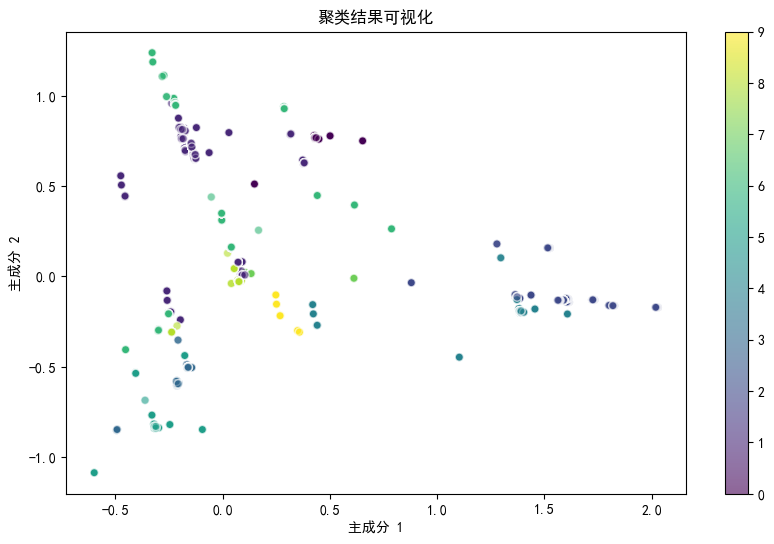

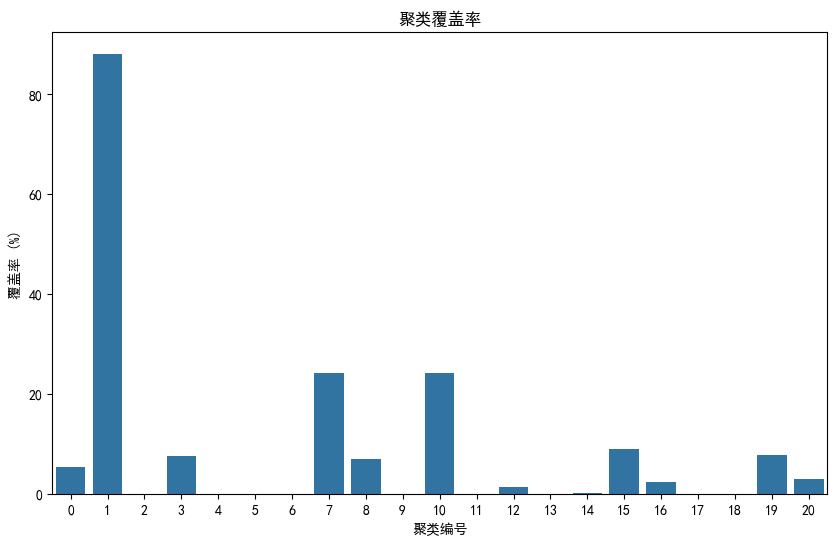

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
import os
import fnmatch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib

# 设置matplotlib以支持中文字体显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False    # 解决保存图像是负号'-'显示为方块的问题

# 载入数据
def load_data(file_path):
    return pd.read_csv(file_path, delimiter='\t', header=None, names=['Process', 'File'])

# 数据向量化
def vectorize_data(data):
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split('/'), max_features=50)
    process_vec = vectorizer.fit_transform(data['Process']).toarray()
    file_vec = vectorizer.fit_transform(data['File']).toarray()
    return process_vec, file_vec

# 数据聚类
def cluster_data(process_vec, file_vec):
    combined_vec = np.hstack((process_vec, file_vec))
    mini_kmeans = MiniBatchKMeans(n_clusters=10, random_state=42)
    labels = mini_kmeans.fit_predict(combined_vec)
    return labels

# 生成详细的规则
def generate_detailed_rules(data, labels):
    rules = {}
    for cluster_id in set(labels):
        cluster_data = data.iloc[labels == cluster_id]
        if not cluster_data.empty:
            process_rules = set(cluster_data['Process'].apply(lambda x: os.path.dirname(x) + '/*').unique())
            file_rules = set(cluster_data['File'].apply(lambda x: os.path.dirname(x) + '/*').unique())
            rules[cluster_id] = (process_rules, file_rules)
    return rules

# 删除冗余规则
def remove_redundant_rules(rules):
    final_rules = []
    for process_rules, file_rules in rules.values():
        simplified_file_rules = simplify_rules(file_rules)
        for process_rule in process_rules:
            final_rules.append((process_rule, simplified_file_rules))
    return final_rules

# 简化规则集
def simplify_rules(rules):
    sorted_rules = sorted(rules, key=lambda x: x.count('/'), reverse=False)
    simplified_rules = set()
    for rule in sorted_rules:
        if not any(fnmatch.fnmatch(rule, f"{existing_rule}/*") for existing_rule in simplified_rules):
            simplified_rules.add(rule)
    return simplified_rules

# 计算覆盖率
def calculate_coverage(data, rules):
    coverage = {}
    total_data = len(data)
    for label, rule in enumerate(rules):
        matches = sum(1 for _, row in data.iterrows() if any(fnmatch.fnmatch(row['Process'], process_rule) and any(fnmatch.fnmatch(row['File'], file_rule) for file_rule in file_rules) for process_rule, file_rules in [rule]))
        coverage[label] = (matches / total_data * 100, matches)
    return coverage

# PCA降维用于可视化
def reduce_dimensions(data):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    return reduced_data

# 绘制聚类结果散点图
def plot_clusters(reduced_data, labels):
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.6, edgecolors='w')
    plt.colorbar()
    plt.title('聚类结果可视化')
    plt.xlabel('主成分 1')
    plt.ylabel('主成分 2')
    plt.show()

# 绘制聚类覆盖率
def plot_coverage(coverage):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(coverage.keys()), y=[cov[0] for cov in coverage.values()])
    plt.title('聚类覆盖率')
    plt.xlabel('聚类编号')
    plt.ylabel('覆盖率 (%)')
    plt.show()

# 主函数
def main():
    file_path = '题目5：fileaccessdata'  # 根据需要调整路径
    data = load_data(file_path)
    process_vec, file_vec = vectorize_data(data)
    labels = cluster_data(process_vec, file_vec)
    reduced_data = reduce_dimensions(np.hstack((process_vec, file_vec)))  # 降维显示

    plot_clusters(reduced_data, labels)  # 绘制聚类散点图

    rules = generate_detailed_rules(data, labels)
    refined_rules = remove_redundant_rules(rules)
    coverage = calculate_coverage(data, refined_rules)
    plot_coverage(coverage)  # 绘制覆盖率图

if __name__ == "__main__":
    main()


c:\Program Files\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


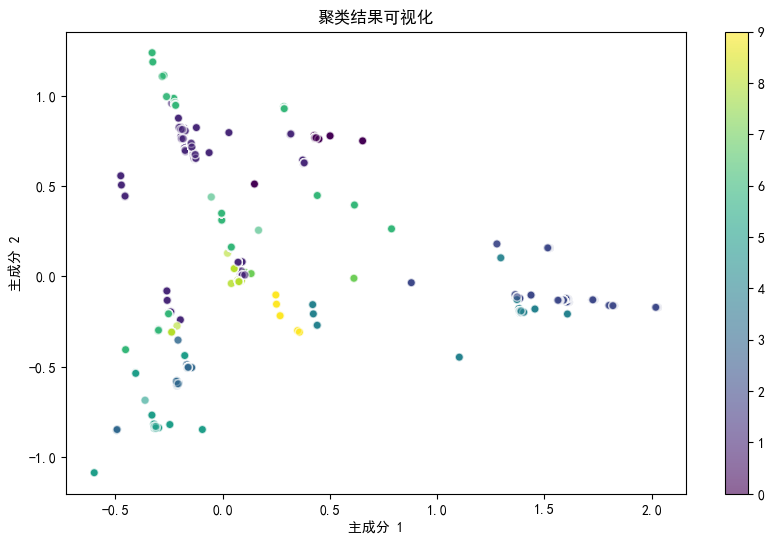

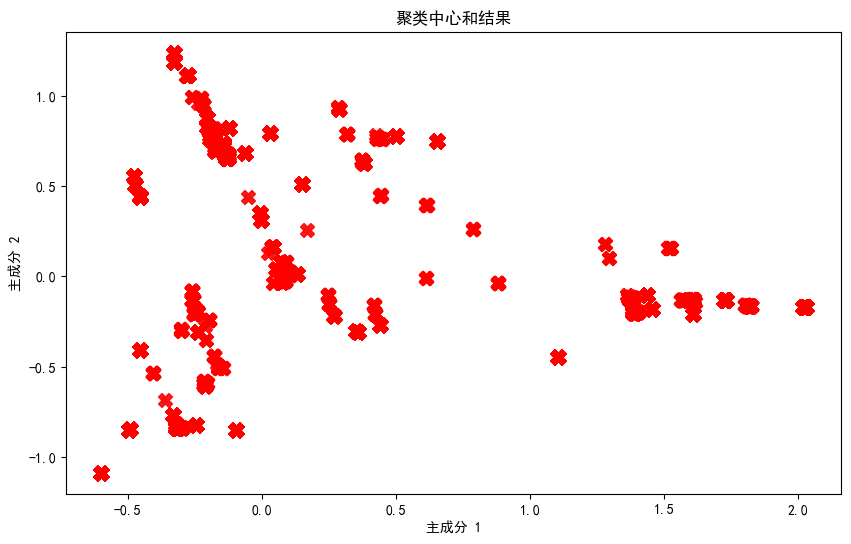

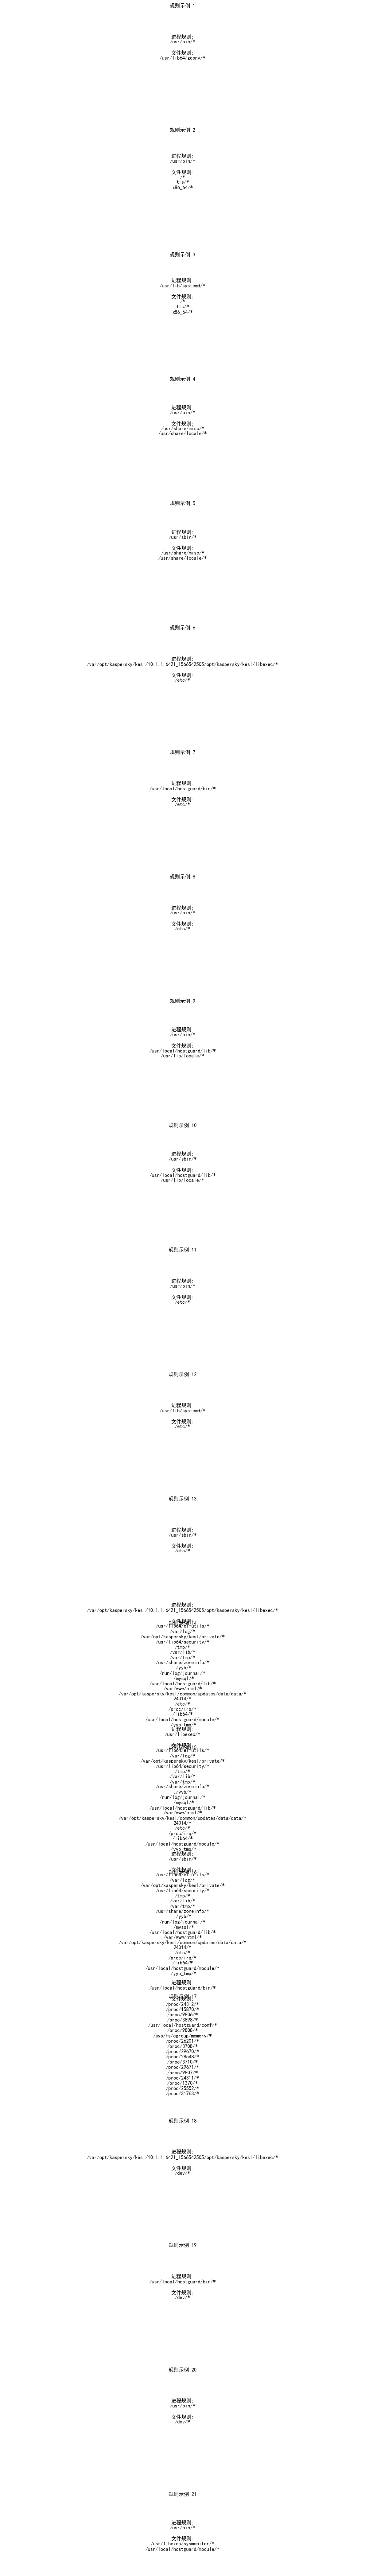

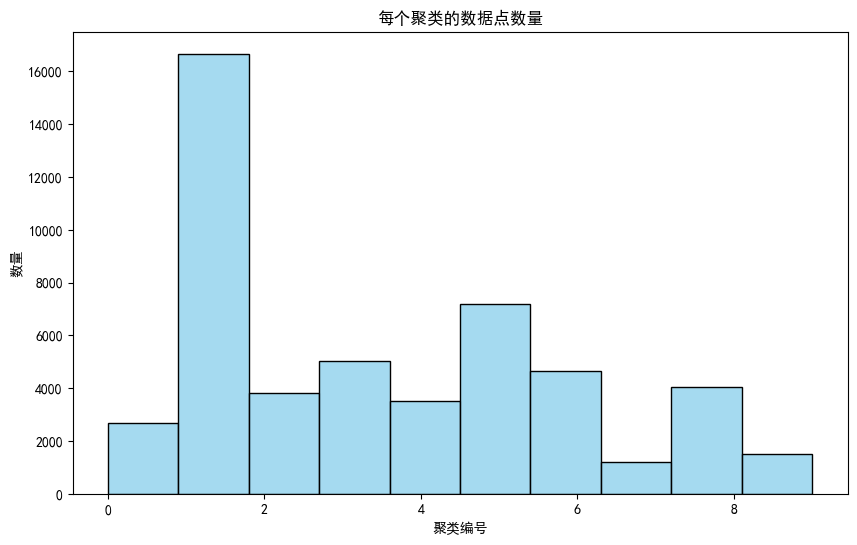

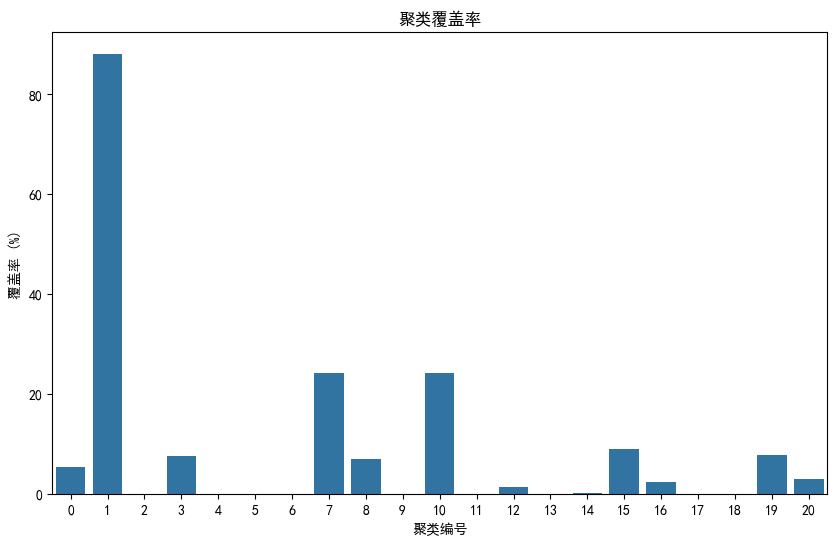

In [5]:
# 绘制聚类中心
def plot_cluster_centers(centers, reduced_data, labels):
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.6, edgecolors='w')
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.9, marker='X')  # 标记聚类中心
    plt.title('聚类中心和结果')
    plt.xlabel('主成分 1')
    plt.ylabel('主成分 2')
    plt.show()

# 绘制每个聚类的规则示例
def plot_cluster_rules(refined_rules):
    fig, axes = plt.subplots(len(refined_rules), 1, figsize=(12, 4 * len(refined_rules)))
    if len(refined_rules) == 1:  # 如果只有一个聚类时，需要特别处理
        axes = [axes]
    for i, (process_rule, file_rules) in enumerate(refined_rules):
        axes[i].set_title(f'规则示例 {i+1}')
        text = f'进程规则:\n{process_rule}\n\n文件规则:\n' + '\n'.join(file_rules)
        axes[i].text(0.5, 0.5, text, horizontalalignment='center', verticalalignment='center', fontsize=12)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# 绘制每个聚类的数据点数量
def plot_data_distribution(labels):
    plt.figure(figsize=(10, 6))
    sns.histplot(labels, bins=len(set(labels)), kde=False, color='skyblue')
    plt.title('每个聚类的数据点数量')
    plt.xlabel('聚类编号')
    plt.ylabel('数量')
    plt.show()

# 主函数
def main():
    file_path = '题目5：fileaccessdata'  # 根据需要调整路径
    data = load_data(file_path)
    process_vec, file_vec = vectorize_data(data)
    labels = cluster_data(process_vec, file_vec)
    reduced_data = reduce_dimensions(np.hstack((process_vec, file_vec)))  # 降维显示

    rules = generate_detailed_rules(data, labels)
    refined_rules = remove_redundant_rules(rules)
    coverage = calculate_coverage(data, refined_rules)
    
    plot_clusters(reduced_data, labels)
    plot_cluster_centers(reduce_dimensions(np.hstack((process_vec, file_vec))), reduced_data, labels)
    plot_cluster_rules(refined_rules)
    plot_data_distribution(labels)
    plot_coverage(coverage)

if __name__ == "__main__":
    main()
